In [1]:
!python -c "import monai" || pip install -q "monai[gdown, nibabel, tqdm, ignite]==0.9.1"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    BoundingRectd,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    Lambdad,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    ToTensord,
)
from monai.apps.detection.transforms.dictionary import (
    AffineBoxToImageCoordinated,
    AffineBoxToWorldCoordinated,
    BoxToMaskd,
    ClipBoxToImaged,
    ConvertBoxToStandardModed,
    MaskToBoxd,
    RandCropBoxByPosNegLabeld,
    RandFlipBoxd,
    RandRotateBox90d,
    RandZoomBoxd,
    ConvertBoxModed
)
from monai.apps.detection.utils.anchor_utils import AnchorGeneratorWithAnchorShape
from monai.apps.detection.metrics.coco import COCOMetric
from monai.apps.detection.metrics.matching import matching_batch
from monai.apps.detection.networks.retinanet_detector import RetinaNetDetector
from monai.apps.detection.networks.retinanet_network import (
    RetinaNet,
    resnet_fpn_feature_extractor,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import resnet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.data.utils import no_collation
from warmup_scheduler import GradualWarmupScheduler
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tempfile
import shutil
import os
import glob
import time
import cv2

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print_config()

MONAI version: 0.9.1
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+08820cb
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.1
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.14.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
root_dir = "./"
amp = True
if amp:
    compute_dtype = torch.float16
else:
    compute_dtype = torch.float32

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        BoundingRectd(keys=["label"], bbox_key_postfix="box"),
        ToTensord(keys=["label_box"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        BoundingRectd(keys=["label"], bbox_key_postfix="box"),
        ToTensord(keys=["label_box"]),
    ]
)

image shape: (228, 158, 113), label shape: (228, 158, 113), box: tensor([35, 78, 54, 99, 62, 93])


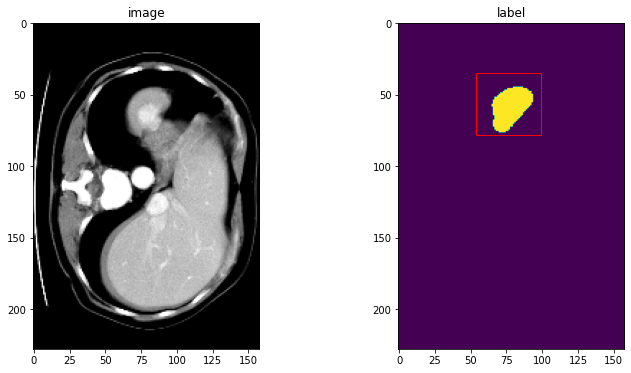

In [8]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label, box = (check_data["image"][0][0], check_data["label"][0][0], check_data["label_box"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}, box: {box}")
# plot the slice [:, :, 80]
rect = patches.Rectangle((box[2], box[0]), box[3]-box[2], box[1]-box[0], linewidth=1, edgecolor='r', facecolor='none')
plt.figure("check", (12, 6))
ax = plt.subplot(1, 2, 1)
plt.title("image")
ax.imshow(image[:, :, 92], cmap="gray")
#ax.add_patch(rect)
ax = plt.subplot(1, 2, 2)
plt.title("label")
ax.imshow(label[:, :, 92])
ax.add_patch(rect)
plt.show()

In [9]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=no_collation)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=no_collation)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.15it/s]


In [10]:
# 3. build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) build anchor generator
# returned_layers: when target boxes are small, set it smaller
# base_anchor_shapes: anchor shape for the most high-resolution output,
#   when target boxes are small, set it smaller
anchor_generator = AnchorGeneratorWithAnchorShape(
    feature_map_scales=[2**l for l in range(len([1,2]) + 1)],
    base_anchor_shapes=[[6,8,4],[8,6,5],[10,10,6]],
)

# 2) build network
conv1_t_size = [max(7, 2 * s + 1) for s in [2,2,1]]
backbone = resnet.ResNet(
    block=resnet.ResNetBottleneck,
    layers=[3, 4, 6, 3],
    block_inplanes=resnet.get_inplanes(),
    n_input_channels=1,
    conv1_t_stride=[2,2,1],
    conv1_t_size=conv1_t_size,
)
feature_extractor = resnet_fpn_feature_extractor(
    backbone=backbone,
    spatial_dims=3,
    pretrained_backbone=False,
    trainable_backbone_layers=None,
    returned_layers=[1,2],
)
num_anchors = anchor_generator.num_anchors_per_location()[0]
size_divisible = [
    s * 2 * 2 ** max([1,2])
    for s in feature_extractor.body.conv1.stride
]
net = torch.jit.script(
    RetinaNet(
        spatial_dims=3,
        num_classes=1,
        num_anchors=num_anchors,
        feature_extractor=feature_extractor,
        size_divisible=size_divisible,
    )
)

# 3) build detector
detector = RetinaNetDetector(
    network=net, anchor_generator=anchor_generator, debug=False
).to(device)

# set training components
detector.set_atss_matcher(num_candidates=4, center_in_gt=False)
detector.set_hard_negative_sampler(
    batch_size_per_image=64,
    positive_fraction=0.3,
    pool_size=20,
    min_neg=16,
)
detector.set_target_keys(box_key="label_box", label_key="label")

# set validation components
detector.set_box_selector_parameters(
    score_thresh=0.02,
    topk_candidates_per_level=1000,
    nms_thresh=0.22,
    detections_per_img=100,
)
detector.set_sliding_window_inferer(
    roi_size=[512,512,208],
    overlap=0.25,
    sw_batch_size=1,
    mode="constant",
    device="cpu",
)

In [11]:
optimizer = torch.optim.SGD(
    detector.network.parameters(),
    1e-2,
    momentum=0.9,
    weight_decay=3e-5,
    nesterov=True,
)
after_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=10, after_scheduler=after_scheduler)
scaler = torch.cuda.amp.GradScaler()
optimizer.zero_grad()
optimizer.step()

In [12]:
# initialize tensorboard writer
tensorboard_writer = SummaryWriter("./logs")

# 5. train
val_interval = 5  # do validation every val_interval epochs
coco_metric = COCOMetric(classes=["spleen"], iou_list=[0.1], max_detection=[100])
best_val_epoch_metric = 0.0
best_val_epoch = -1  # the epoch that gives best validation metrics
max_epochs = 300
epoch_len = len(train_ds) // train_loader.batch_size
w_cls = 1.0  # weight between classification loss and box regression loss, default 1.0
for epoch in range(max_epochs):
    # ------------- Training -------------
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    detector.train()
    epoch_loss = 0
    epoch_cls_loss = 0
    epoch_box_reg_loss = 0
    step = 0
    start_time = time.time()
    scheduler_warmup.step()
    # Training
    for batch_data in train_loader:
        step += 1
        inputs = [
            batch_data_ii["image"].to(device)
            for batch_data_i in batch_data
            for batch_data_ii in batch_data_i
        ]
        targets = [
            dict(
                label=batch_data_ii["label"].to(device),
                label_box=batch_data_ii["label_box"].to(device),
            )
            for batch_data_i in batch_data
            for batch_data_ii in batch_data_i
        ]

        for param in detector.network.parameters():
            param.grad = None

        if amp and (scaler is not None):
            with torch.cuda.amp.autocast():
                outputs = detector(inputs, targets)
                loss = (
                    w_cls * outputs[detector.cls_key]
                    + outputs[detector.box_reg_key]
                )
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = detector(inputs, targets)
            loss = w_cls * outputs[detector.cls_key] + outputs[detector.box_reg_key]
            loss.backward()
            optimizer.step()

        # save to tensorboard
        epoch_loss += loss.detach().item()
        epoch_cls_loss += outputs[detector.cls_key].detach().item()
        epoch_box_reg_loss += outputs[detector.box_reg_key].detach().item()
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        tensorboard_writer.add_scalar(
            "train_loss", loss.detach().item(), epoch_len * epoch + step
        )

    end_time = time.time()
    print(f"Training time: {end_time-start_time}s")
    del inputs, batch_data
    torch.cuda.empty_cache()
    gc.collect()

    # save to tensorboard
    epoch_loss /= step
    epoch_cls_loss /= step
    epoch_box_reg_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    tensorboard_writer.add_scalar("avg_train_loss", epoch_loss, epoch + 1)
    tensorboard_writer.add_scalar("avg_train_cls_loss", epoch_cls_loss, epoch + 1)
    tensorboard_writer.add_scalar(
        "avg_train_box_reg_loss", epoch_box_reg_loss, epoch + 1
    )
    tensorboard_writer.add_scalar(
        "train_lr", optimizer.param_groups[0]["lr"], epoch + 1
    )

    # save last trained model
    torch.jit.save(detector.network,env_dict["model_path"][:-3] + "_last.pt")
    print("saved last model")

    # ------------- Validation for model selection -------------
    if (epoch + 1) % val_interval == 0:
        detector.eval()
        val_outputs_all = []
        val_targets_all = []
        start_time = time.time()
        with torch.no_grad():
            for val_data in val_loader:
                # if all val_data_i["image"] smaller than args.val_patch_size, no need to use inferer
                # otherwise, need inferer to handle large input images.
                use_inferer = not all(
                    [
                        val_data_i["image"][0, ...].numel()
                        < np.prod([512,512,208])
                        for val_data_i in val_data
                    ]
                )
                val_inputs = [
                    val_data_i.pop("image").to(device) for val_data_i in val_data
                ]

                if amp:
                    with torch.cuda.amp.autocast():
                        val_outputs = detector(val_inputs, use_inferer=use_inferer)
                else:
                    val_outputs = detector(val_inputs, use_inferer=use_inferer)

                # save outputs for evaluation
                val_outputs_all += val_outputs
                val_targets_all += val_data

        end_time = time.time()
        print(f"Validation time: {end_time-start_time}s")

        # visualize an inference image and boxes to tensorboard
        draw_img = visualize_one_xy_slice_in_3d_image(
            gt_boxes=val_data[0]["label_box"].cpu().detach().numpy(),
            image=val_inputs[0][0, ...].cpu().detach().numpy(),
            pred_boxes=val_outputs[0][detector.target_box_key]
            .cpu()
            .detach()
            .numpy(),
        )
        tensorboard_writer.add_image(
            "val_img_xy", draw_img.transpose([2, 1, 0]), epoch + 1
        )

        # compute metrics
        del val_inputs
        torch.cuda.empty_cache()
        results_metric = matching_batch(
            iou_fn=box_utils.box_iou,
            iou_thresholds=coco_metric.iou_thresholds,
            pred_boxes=[
                val_data_i[detector.target_box_key].cpu().detach().numpy()
                for val_data_i in val_outputs_all
            ],
            pred_classes=[
                val_data_i[detector.target_label_key].cpu().detach().numpy()
                for val_data_i in val_outputs_all
            ],
            pred_scores=[
                val_data_i[detector.pred_score_key].cpu().detach().numpy()
                for val_data_i in val_outputs_all
            ],
            gt_boxes=[
                val_data_i[detector.target_box_key].cpu().detach().numpy()
                for val_data_i in val_targets_all
            ],
            gt_classes=[
                val_data_i[detector.target_label_key].cpu().detach().numpy()
                for val_data_i in val_targets_all
            ],
        )
        val_epoch_metric_dict = coco_metric(results_metric)[0]
        print(val_epoch_metric_dict)

        # write to tensorboard event
        for k in val_epoch_metric_dict.keys():
            tensorboard_writer.add_scalar(
                "val_" + k, val_epoch_metric_dict[k], epoch + 1
            )
        val_epoch_metric = val_epoch_metric_dict.values()
        val_epoch_metric = sum(val_epoch_metric) / len(val_epoch_metric)
        tensorboard_writer.add_scalar("val_metric", val_epoch_metric, epoch + 1)

        # save best trained model
        if val_epoch_metric > best_val_epoch_metric:
            best_val_epoch_metric = val_epoch_metric
            best_val_epoch = epoch + 1
            torch.jit.save(detector.network, env_dict["model_path"])
            print("saved new best metric model")
        print(
            "current epoch: {} current metric: {:.4f} "
            "best metric: {:.4f} at epoch {}".format(
                epoch + 1, val_epoch_metric, best_val_epoch_metric, best_val_epoch
            )
        )

print(
    f"train completed, best_metric: {best_val_epoch_metric:.4f} "
    f"at epoch: {best_val_epoch}"
)
tensorboard_writer.close()

----------
epoch 1/300


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/monai/apps/detection/networks/retinanet_network.py", line 189, in forward
    
        for features in feature_maps:
            box_regression = self.conv(features)
                             ~~~~~~~~~ <--- HERE
            box_regression = self.bbox_reg(box_regression)
    
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py", line 139, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/normalization.py", line 272, in forward
    def forward(self, input: Tensor) -> Tensor:
        return F.group_norm(
               ~~~~~~~~~~~~ <--- HERE
            input, self.num_groups, self.weight, self.bias, self.eps)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py", line 2514, in group_norm
        return handle_torch_function(group_norm, (input, weight, bias,), input, num_groups, weight=weight, bias=bias, eps=eps)
    _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))
    return torch.group_norm(input, num_groups, weight, bias, eps, torch.backends.cudnn.enabled)
           ~~~~~~~~~~~~~~~~ <--- HERE
RuntimeError: CUDA out of memory. Tried to allocate 216.00 MiB (GPU 0; 6.00 GiB total capacity; 5.15 GiB already allocated; 0 bytes free; 5.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
